# Reproduction of Ganspace

This notebook consists of additional experiments which are not a part of the original paper, as well as a playground that enables the user to generate his/her own edits.

In [1]:
#@title Install the required packages (Please manually restart runtime after installation)
!pip install fbpca dvc==2.3.0

     |████████████████████████████████| 632 kB 5.4 MB/s 
     |████████████████████████████████| 212 kB 29.3 MB/s 
     |████████████████████████████████| 41 kB 21 kB/s 
     |████████████████████████████████| 530 kB 41.7 MB/s 
     |████████████████████████████████| 44 kB 2.6 MB/s 
     |████████████████████████████████| 109 kB 44.2 MB/s 
     |████████████████████████████████| 48 kB 4.9 MB/s 
     |████████████████████████████████| 111 kB 45.2 MB/s 
     |████████████████████████████████| 180 kB 44.9 MB/s 
     |████████████████████████████████| 4.6 MB 37.9 MB/s 
     |████████████████████████████████| 296 kB 48.6 MB/s 
     |████████████████████████████████| 49 kB 5.4 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 64 kB 1.7 MB/s 
     |████████████████████████████████| 2.6 MB 35.0 MB/s 
     |████████████████████████████████| 201 kB 47.3 MB/s 
     |████████████████████████████████| 51 kB 7.1 MB/s 
     |████████████████████████

In [1]:
#Set the tensorflow version to 1.x
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Setup

Clone the repository and install the required packages

In [2]:
#@title Clone the repository
#Clone: https://dagshub.com/midsterx/Re-GANSpace
!git clone https://dagshub.com/midsterx/Re-GANSpace
%cd Re-GANSpace

Cloning into 'Re-GANSpace'...
remote: Enumerating objects: 356, done.
remote: Counting objects: 100% (356/356), done.
remote: Compressing objects: 100% (342/342), done.
remote: Total 356 (delta 95), reused 167 (delta 10)
Receiving objects: 100% (356/356), 105.65 MiB | 25.48 MiB/s, done.
Resolving deltas: 100% (95/95), done.
/content/Re-GANSpace


In [3]:
#@title (Optional but recommended) Download StyleGAN/StyleGAN2 pretrained models using DVC
!dvc pull -r origin

Streaming output truncated to the last 5000 lines.







          |211M [00:41,    6.04MB/s]
          |198M [00:37,    6.22MB/s]


          |177M [00:31,    5.90MB/s]




          |172M [00:32,    5.94MB/s]







          |212M [00:41,    6.04MB/s]






          |161M [00:27,    6.21MB/s]





          |231M [00:44,    5.81MB/s]


          |178M [00:31,    6.04MB/s]




          |172M [00:32,    6.40MB/s]







          |213M [00:41,    5.63MB/s]






          |161M [00:27,    5.77MB/s]





          |231M [00:44,    5.35MB/s]


          |178M [00:31,    5.81MB/s]
          |200M [00:37,    5.97MB/s]




          |173M [00:32,    6.17MB/s]







          |213M [00:41,    5.68MB/s]






          |162M [00:27,    5.70MB/s]





          |232M [00:44,    5.19MB/s]
          |200M [00:37,    5.79MB/s]




          |174M [00:32,    6.01MB/s]







          |214M [00:41,    6.30MB/s]


          |180M [00:32,    6.36MB/s]
          |201M [00:38,    5.95MB/s]








In [4]:
#@title Import necessary functions and change directories
#Import helper function to render images in notebook
from IPython.display import Image

In [5]:
import sys
sys.path.append('./models/stylegan2')

from pathlib import Path
import dnnlib.tflib as tflib
import matplotlib.pyplot as plt
import numpy as np
import os

from decomposition import load_network, pca
from utils import centre_strip_stylegan, out_classes

SAVE_PATH = './results'

tflib.init_tf()

In [6]:
def generate_figure(stylegan_version, truncation_psi, output_class, estimator,
                    batch_size, num_components, num_samples, l_start, l_end,
                    sigma, idx, seed, figure_name):
    Gs, Gs_kwargs = load_network(output_class, stylegan_version)
    Gs_kwargs.truncation_psi = truncation_psi

    # Get noise variables
    noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

    # Add noise
    rnd = np.random.RandomState(0)
    tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars})  # [height, width]

    # Compute PCA
    dump_path = pca(Gs, stylegan_version, output_class, estimator, batch_size, num_components, num_samples)
    w_avg = Gs.get_var('dlatent_avg')

    out_root = Path('out/directions')
    os.makedirs(out_root, exist_ok=True)

    input_shape = Gs.input_shape[1]
    num_layers = Gs.components.mapping.output_shape[1]

    grid = []
    strips = []

    # Load computed PCA components
    with np.load(dump_path) as data:
        X_comp = data['act_comp']
        X_global_mean = data['act_mean']
        X_stdev = data['act_stdev']
        Z_comp = data['lat_comp']
        Z_global_mean = data['lat_mean']
        Z_stdev = data['lat_stdev']

    feat_shape = X_comp[0].shape
    sample_dims = np.prod(feat_shape)

    edit_start = l_start
    edit_end = num_layers if l_end == -1 else l_end

    print("Seed:", seed)
    # Sample latent
    rnd = np.random.RandomState(seed)
    z = rnd.randn(1, *Gs.input_shape[1:])

    # Generate image
    batch_frames = centre_strip_stylegan(Gs, Gs_kwargs, z, Z_comp, Z_global_mean, Z_stdev, idx, sigma, 5, edit_start, edit_end)
    strips.append(np.hstack(batch_frames))

    grid = np.vstack(strips)
    plt.figure(figsize=(15, 15))
    plt.imshow(grid, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(os.path.join(SAVE_PATH, '{}.png'.format(figure_name)), bbox_inches='tight')

# Additional results not present in the original paper

In addition to reproducing the paper results, we ran our own experiments on several pretrained GAN models and obtained new results which are not present in the original paper.

### New edits

We identify new edits on the Stylegan2 Beetles dataset. The edit adds a pattern on the shell of the beetle. The generated pattern varies depending on the seed used to sample w.

[08.10 17:48] Computing stylegan2-beetles_ipca_c80_n1000000_w.npz
Using W latent space
Feature shape:  (1, 512)
Feature dims:  512
B=20, N=1000000, dims=512, N/dims=1953.1


Fitting batches (NB=2000): 100%|##########| 500/500 [03:02<00:00,  2.75it/s]


Seed: 1819967864


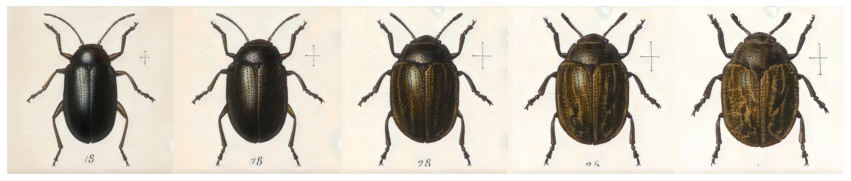

In [7]:
#@title Beetle with Patterns generated with seed 1819967864
generate_figure(2, 0.7, 'beetles', 'ipca', 20, 80, 1000000, 0, 17, -2.5, 2, 1819967864, 'new_edits')

### Truncation Psi on StyleGAN

The original authors use the "truncation trick" on images generated using StyleGAN2 to improve their quality. However, this is not enabled for StyleGAN images. During our experimentation, we found that enabling truncation while applying edits on StyleGAN images improved their quality as well.

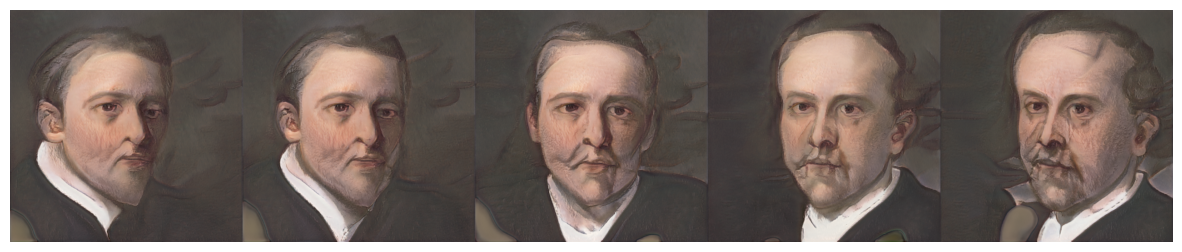

In [10]:
#@title Original image with no truncation
Image(os.path.join(SAVE_PATH,'figure7_StyleGAN_wikiart_Head-rotation.png'))

[08.10 18:07] Computing stylegan1-wikiart_ipca_c80_n1000000_w.npz
Using W latent space
Feature shape:  (1, 512)
Feature dims:  512
B=20, N=1000000, dims=512, N/dims=1953.1


Fitting batches (NB=2000): 100%|##########| 500/500 [03:07<00:00,  2.67it/s]


Seed: 1819967864


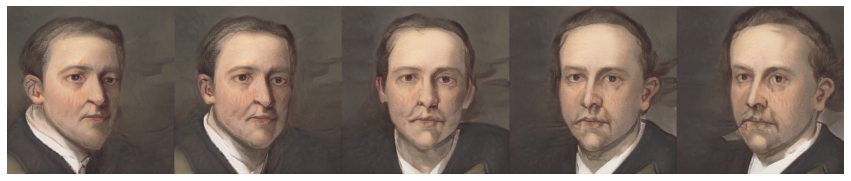

In [11]:
#@title Our image with truncation
generate_figure(1, 0.7, 'wikiart', 'ipca', 20, 80, 1000000, 0, 2, -2.9, 7, 1819967864, 'stylegan_truncation_psi')

# Playground


In [20]:
#@title Select configuration parameters

# stylegan1/2 pretrained on ffhq
stylegan_version = "2" #@param ["1", "2"]
output_class = "anime" #@param ["celebahq", "ffhq", "wikiart", "anime", "cars", "cats", "horse", "ukiyoe", "beetles"]
batch_size = 20 #@param {type:"slider", min:1, max:100, step:1}
num_components = 80 #@param {type:"slider", min:1, max:100, step:1}
num_samples = 1000000 #@param {type:"slider", min:1, max:1000000, step:1}

# whatever is present in stylegan cache
layer_start = 0 #@param {type:"slider", min:0, max:16, step:1}
layer_end = 15 #@param {type:"slider", min:1, max:17, step:1}
# use assert statements for layer start and end, depending on the dataset
sigma = -10.03 #@param {type:"slider", min:-50, max:50, step:0.01}
pca_index = 51 #@param {type:"slider", min:0, max:79, step:1}
seed = 425352 #@param {type:"slider", min:0, max:4294967295, step:1}
truncation_psi = 0.7 #@param {type:"slider", min:0, max:1, step:0.01}

In [21]:
#@title Check validity of configuration parameters
if layer_start > layer_end:
    raise Exception('Selected start layer is greater than end layer')

# 256x256 images
if output_class in ['cats', 'horse', 'ukiyoe'] and (layer_start > 12 or layer_end > 13):
    raise Exception('Model does not support selected layer')

# 512x512 images
if output_class in ['anime', 'cars', 'wikiart'] and (layer_start > 14 or layer_end > 15):
    raise Exception('Model does not support selected layer')

if int(stylegan_version) == 1 and output_class in ['beetles', 'cat', 'cars', 'horse', 'ukiyoe']:
    raise Exception('Pretrained model not found')
elif int(stylegan_version) == 2 and output_class in ['celebahq', 'wikiart']:
    raise Exception('Pretrained model not found')

Seed: 425352


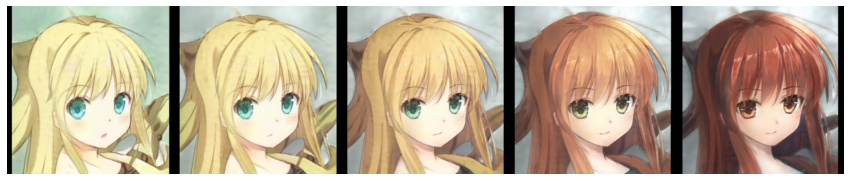

In [22]:
#@title Generate your edit
generate_figure(int(stylegan_version), truncation_psi, output_class, 'ipca',
                batch_size, num_components, num_samples, layer_start, layer_end,
                sigma, pca_index, seed, 'figure_playground')